In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import sys
from importlib import reload
from pathlib import Path
import scanpy as sc
from pylab import rcParams
from matplotlib.patches import Patch
import re
import seaborn as sns
import glob

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import scvelo as scv
scv.logging.print_version()


scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params('scvelo')  # for beautified visualization

%matplotlib inline

Running scvelo 0.2.2 (python 3.8.3) on 2020-11-06 14:23.


In [3]:
###----- Get dir & load / reload packages
try:
    code_dir
except NameError:
    print("Start")
    code_dir = os.getcwd()
    base_dir = code_dir.replace("/plotting_codes","")
    tools_dir = base_dir + "/tools"

    sys.path.insert(1, tools_dir)
    import sc_addons
    import sc_pl_addons
else:
    print("Reload")
    reload(sc_addons)
    reload(sc_pl_addons)

Start


In [4]:
## ----- Setup working dir
sp_name = "1_IL2RAKO"
analysis_name = ["0", "all"] 

wk_dir = base_dir + "/9_Figures/%s/%s_%s"%(sp_name, analysis_name[0], analysis_name[1])
Path(wk_dir).mkdir(parents=True, exist_ok=True)
os.chdir(wk_dir)

print(sp_name)

1_IL2RAKO


In [47]:
###----- old - new cluster names
order_file = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/1_IL2RAKO/1_Scanpy/0-all_Scanpy_out/0_sum/1_IL2RAKO_obs_louvainAvg.csv'
order_df = pd.read_csv(order_file)
louvain_new_ordered = order_df['louvain_new_label'].tolist()
louvain_old_ordered = order_df['louvain'].tolist()

In [48]:
adata_h5ad = '%s/%s/1_Scanpy'%(base_dir, sp_name) + '/%s-%s_Scanpy_out/%s_paga.h5ad'%(analysis_name[0], analysis_name[1], sp_name)
adata = sc.read_h5ad(adata_h5ad)

#--- Match old & new louvain levels
adata.obs['louvain_old'] = adata.obs['louvain']
adata.uns['louvain_old_colors'] = adata.uns['louvain_colors']
adata.obs['louvain'] = [ louvain_new_ordered[louvain_old_ordered.index(int(x))] for x in adata.obs['louvain'] ]
category_order = order_df.sort_values('louvain')['louvain_new_label'].tolist()
adata.obs['louvain'] = pd.Categorical(adata.obs['louvain'].tolist(), categories=category_order) # The key is to set categories according to original order...
adata.uns['louvain_colors'] = ['slategray',  'orchid','orange', 'sienna', 'dodgerblue','dimgray',  'lightgray' ,'purple', 'forestgreen','red']

adata.obs['cell_id'] = adata.obs.index.tolist()

# 1. Scatterplots

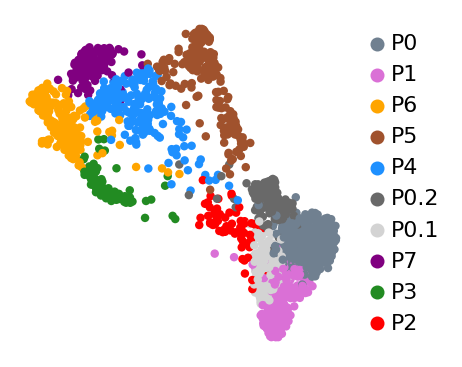

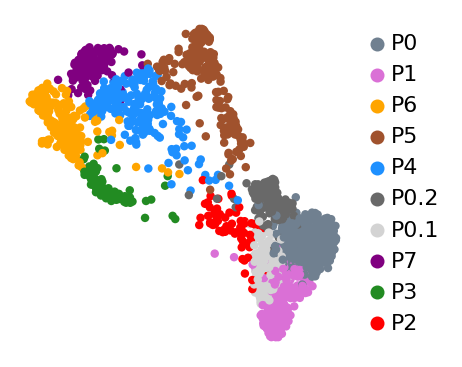

In [49]:
### New louvain cluster numeric order plot
save_name = '_louvain_new_scatter_with_leg'

### Plot
rcParams['figure.figsize'] = 3, 3

sc.pl.draw_graph(adata, color=['louvain'], frameon=False, save = save_name + '.png', title='')
sc.pl.draw_graph(adata, color=['louvain'], frameon=False, save = save_name + '.pdf', title='')

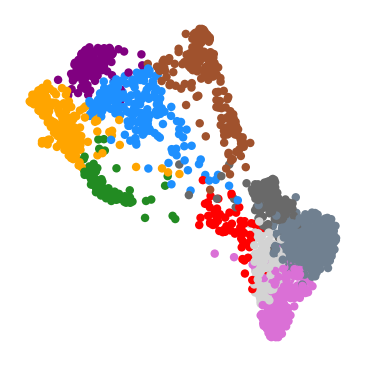

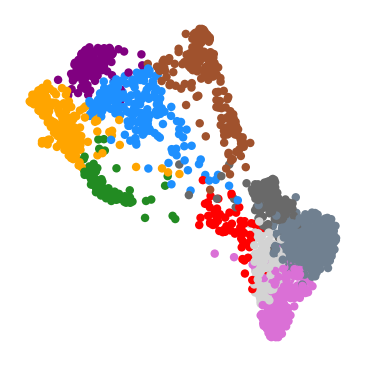

In [50]:
### New louvain cluster numeric order plot
save_name = '_louvain_new_scatter'

### Plot
rcParams['figure.figsize'] = 3, 3

sc.pl.draw_graph(adata, color=['louvain'], frameon=False, legend_loc=None, save = save_name + '.png', title='')
sc.pl.draw_graph(adata, color=['louvain'], frameon=False, legend_loc=None, save = save_name + '.pdf', title='')

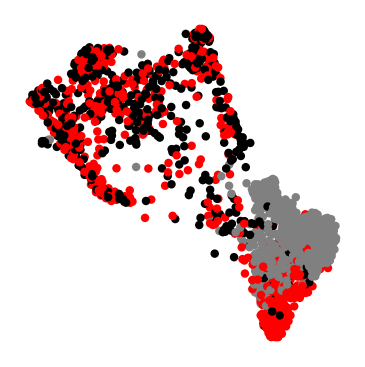

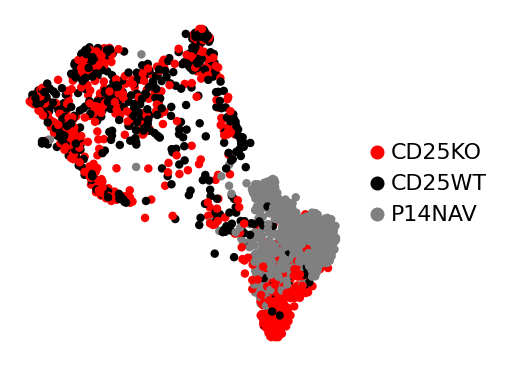

In [51]:
### Hightlight by day
save_name = '_KO_vs_WT'

### Plot
adata.uns['cell_type_colors'] = np.array(['red', 'black', 'grey'])
rcParams['figure.figsize'] = 3, 3
sc.pl.draw_graph(adata, color=['cell_type'], frameon=False, save=save_name + '.png',  legend_loc=None, title='')
sc.pl.draw_graph(adata, color=['cell_type'], frameon=False, save=save_name + '.pdf', title='')

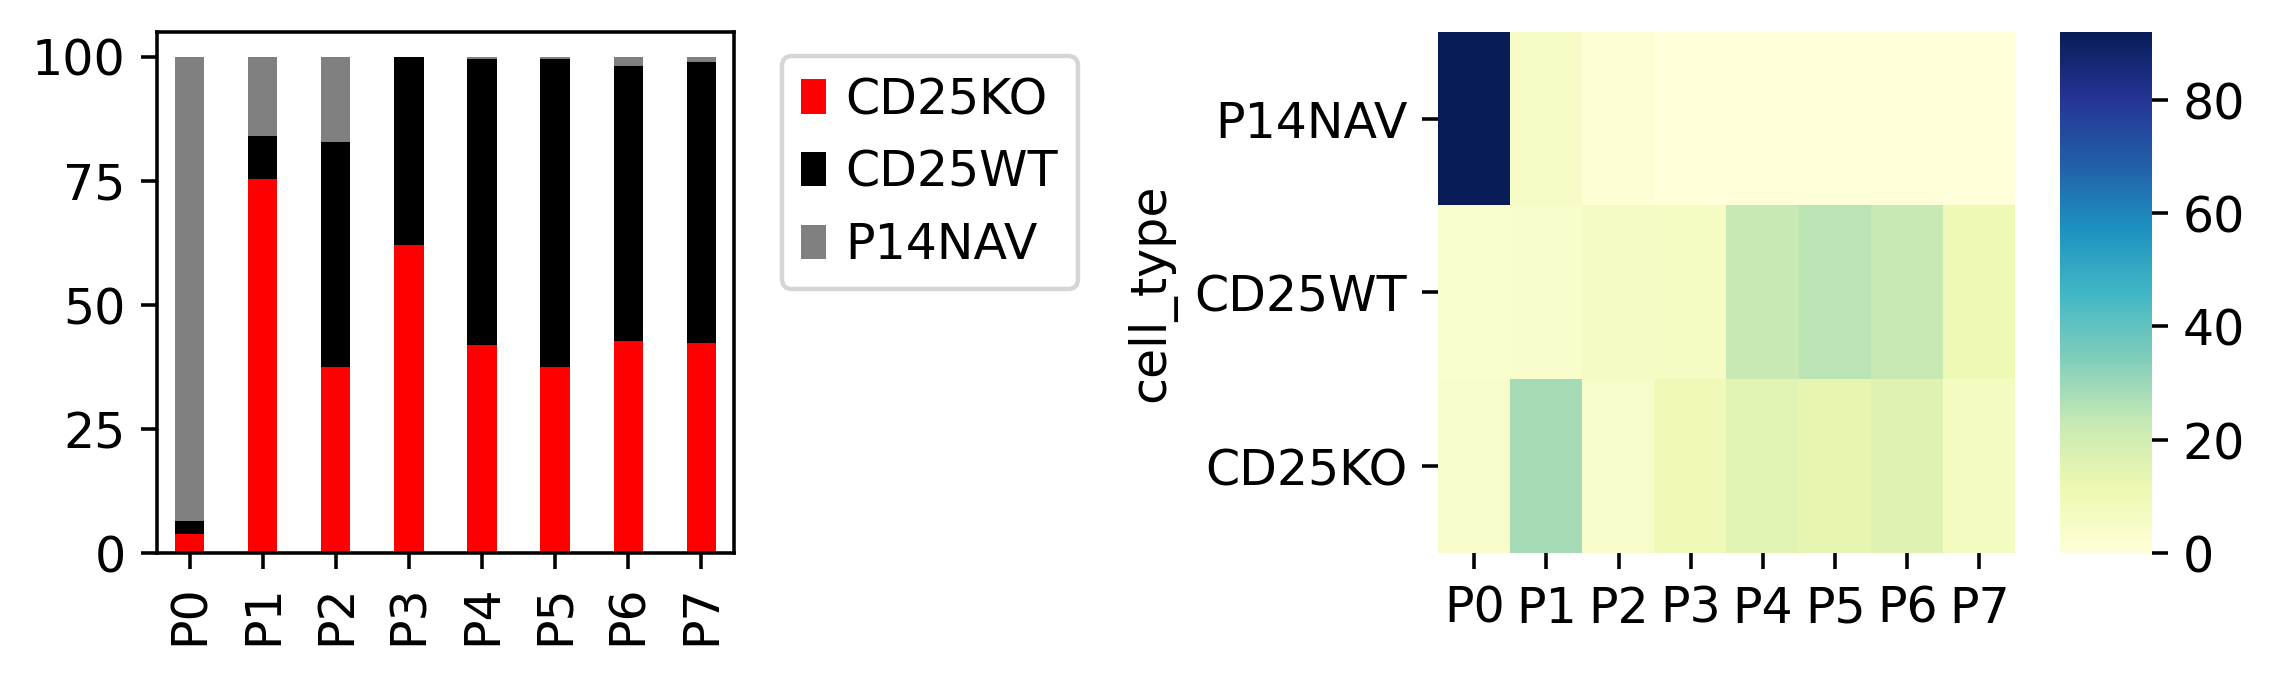

In [36]:
### Hightlight by day
save_name = 'Louvain_cell-type_distribution'

### Plot
fig, axes = plt.subplots(ncols=2, nrows=1, sharey=False, figsize=(7,2), constrained_layout = True, dpi=160)

col_list = ['red', 'black', 'grey']
sum_df = sc_pl_addons.count_pctg_stack_bars(adata,  'louvain', 'cell_type','cell_id', 
                                   None, None, axes[0], col_list,True)

key1 = 'louvain'
key2 = 'cell_type'
count = 'cell_id'
sum_df = adata.obs.reset_index()[[key1, key2, count]].drop_duplicates(count).groupby([key1, key2]).count()[[count]].unstack(key1)
sum_df.columns = [x[1] for x in sum_df.columns.values] 
sum_df[np.isnan(sum_df)] = 0
for i in range(0, len(sum_df)):
    sum_df.iloc[i] = sum_df.iloc[i] / sum(sum_df.iloc[i]) * 100
sum_df_cols = sum_df.columns.tolist()
sum_df_cols = sorted(sum_df_cols, key=lambda x: int(re.findall("\d+", x)[0]))
sum_df = sum_df[sum_df_cols]

sum_df_plot = sum_df.loc[['P14NAV', 'CD25WT', 'CD25KO'], :]
sns.heatmap(sum_df_plot, cmap='YlGnBu', ax=axes[1])

plt.show()
fig.savefig(save_name + '.png')
fig.savefig(save_name + '.pdf')
plt.close()